In [1]:
import argparse
import importlib
import os
import time
from datetime import datetime
from functools import partial
from pathlib import Path

import cartopy.crs as ccrs
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from geopy.distance import geodesic
from matplotlib.lines import Line2D
from mpl_toolkits import axes_grid1
from scipy.spatial import KDTree
from scipy.stats._continuous_distns import genpareto
from statsmodels.distributions.empirical_distribution import ECDF
from tqdm.auto import tqdm

import grapher

# Custom
import mstmeclass as mc
from mstmeclass import MSTME, SIMSET, STM, Area

# Load data

In [2]:
region = "guadeloupe-wide"
N_subsample = 100
rf = "none"
RECALC = True

In [6]:
path_notebook = Path(f"notebook_{region}_{rf}.dill")
if path_notebook.exists() and not RECALC:
    with open(path_notebook, "rb") as f:
        dill.load_session(f)
else:
    columns = [
        "thr_mar_pct",
        "thr_com_pct",
        "thr_mar",
        "thr_com",
        "count",
        "kt_fail_ratio",
        "shape_param",
    ]
    data = []
    clusters = []

    thr_mar_list = [
        0.6,
    ]
    thr_com_list = [
        0.60,
        # 0.65,
        0.70,
        # 0.75,
        0.80,
        # 0.85,
        0.90,
    ]

    for i, thr_pct_mar in enumerate(thr_mar_list):
        for j, thr_pct_com in enumerate(thr_com_list):
            path = Path(
                f"./output/{region}/{rf}/GP{round(thr_pct_mar*100)}%_CM{round(thr_pct_com*100)}%_{N_subsample}subsamples/mstme_condition.dill"
            )
            with open(path, "rb") as f:
                try:
                    cluster: MSTME = dill.load(f)
                except:
                    print(thr_pct_mar, thr_pct_com)
                    continue
                if cluster.thr_pct_com in [0.90, 0.95]:
                    continue
                # elif cluster.thr_pct_mar:
                #     continue
                clusters.append(cluster)
                if i == 0 and j == 0:
                    tree = KDTree(cluster.latlon)
                    grid_res = 10
                    lat_list = np.linspace(
                        cluster.area.min_lat, cluster.area.max_lat, grid_res
                    )
                    lon_list = np.linspace(
                        cluster.area.min_lon, cluster.area.max_lon, grid_res
                    )
                    dist_list, pos_list = tree.query(
                        [[[lat, lon] for lat in lat_list] for lon in lon_list]
                    )
                    pos_list = pos_list.flatten()
                    pos_list = np.unique(pos_list)
                if not hasattr(cluster, "pval"):
                    cluster.calc_kendall_tau()
                # print(
                #     f"{cluster.thr_pct_mar}\t{cluster.thr_pct_com}\t{cluster.thr_mar}\t{cluster.thr_com}\t{np.count_nonzero(cluster.is_e,axis=1)}\t{ratio_kt_fail[0,0]}\t{ratio_kt_fail[1,1]}"
                # )

            with open(path, "wb") as f:
                dill.dump(cluster, f)
    cl_arr = np.array(clusters, dtype=MSTME).reshape(
        (len(thr_mar_list), len(thr_com_list))
    )

ValueError: cannot reshape array of size 3 into shape (1,4)

In [7]:
for cl in clusters:
    print(cl.thr_pct_com)

0.6
0.7
0.8


In [19]:
dir_out = Path(f"./output/{region}/summary/NO_MAX_THR/{rf}")
if not dir_out.exists():
    dir_out.mkdir(parents=True, exist_ok=True)

# Marginal threshold choice

## Convex hull of a,b over marginal thresholds

In [20]:
from scipy.spatial import ConvexHull
viridis = plt.colormaps['viridis']

def remap(x, in_min, in_max, out_min, out_max):
  return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

0.6 0.6
0.65 0.6
0.7 0.6
0.75 0.6
0.8 0.6
0.6 0.65
0.65 0.65
0.7 0.65
0.75 0.65
0.8 0.65
0.6 0.7
0.65 0.7
0.7 0.7
0.75 0.7
0.8 0.7
0.6 0.75
0.65 0.75
0.7 0.75
0.75 0.75
0.8 0.75
0.6 0.8
0.65 0.8
0.7 0.8
0.75 0.8
0.8 0.8


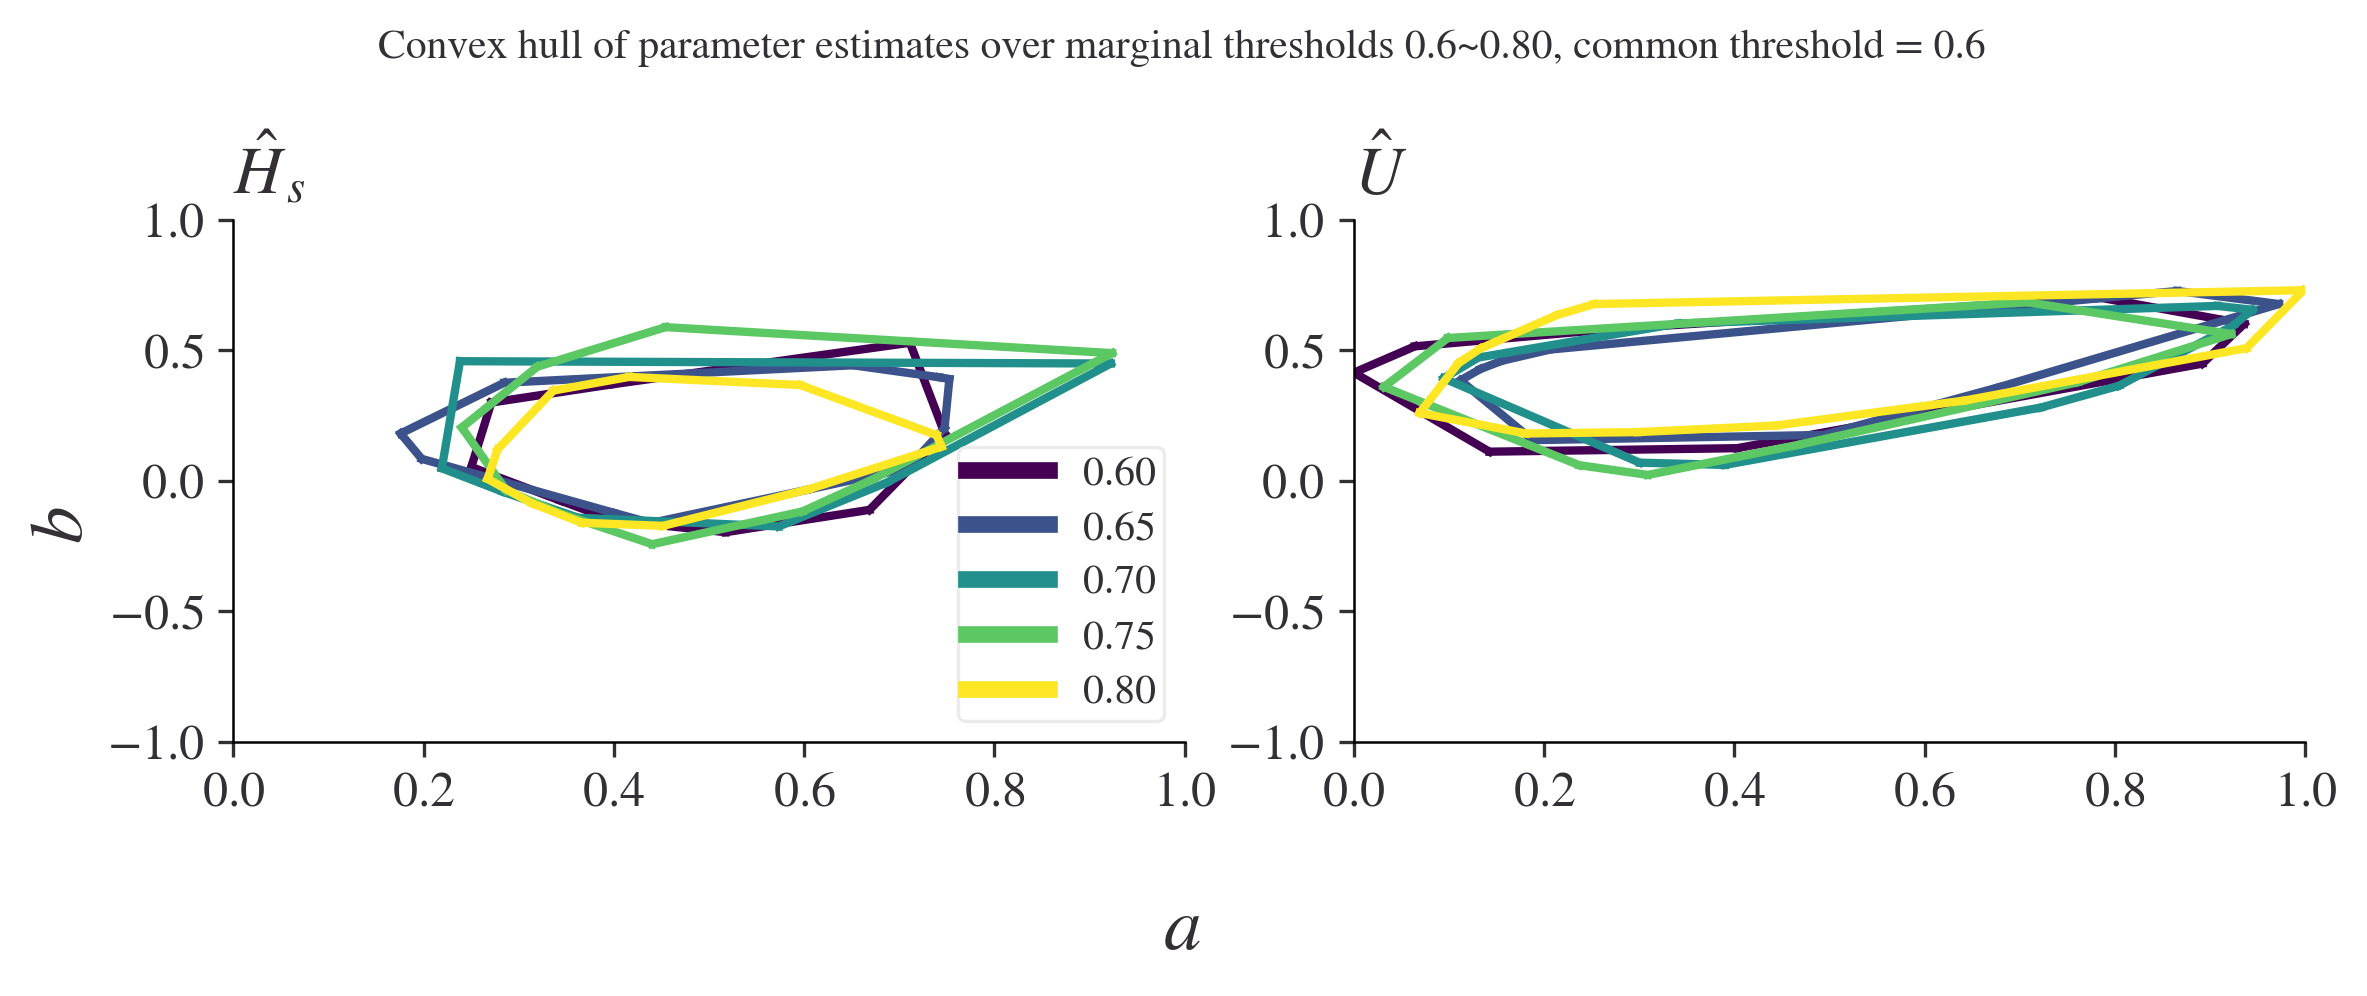

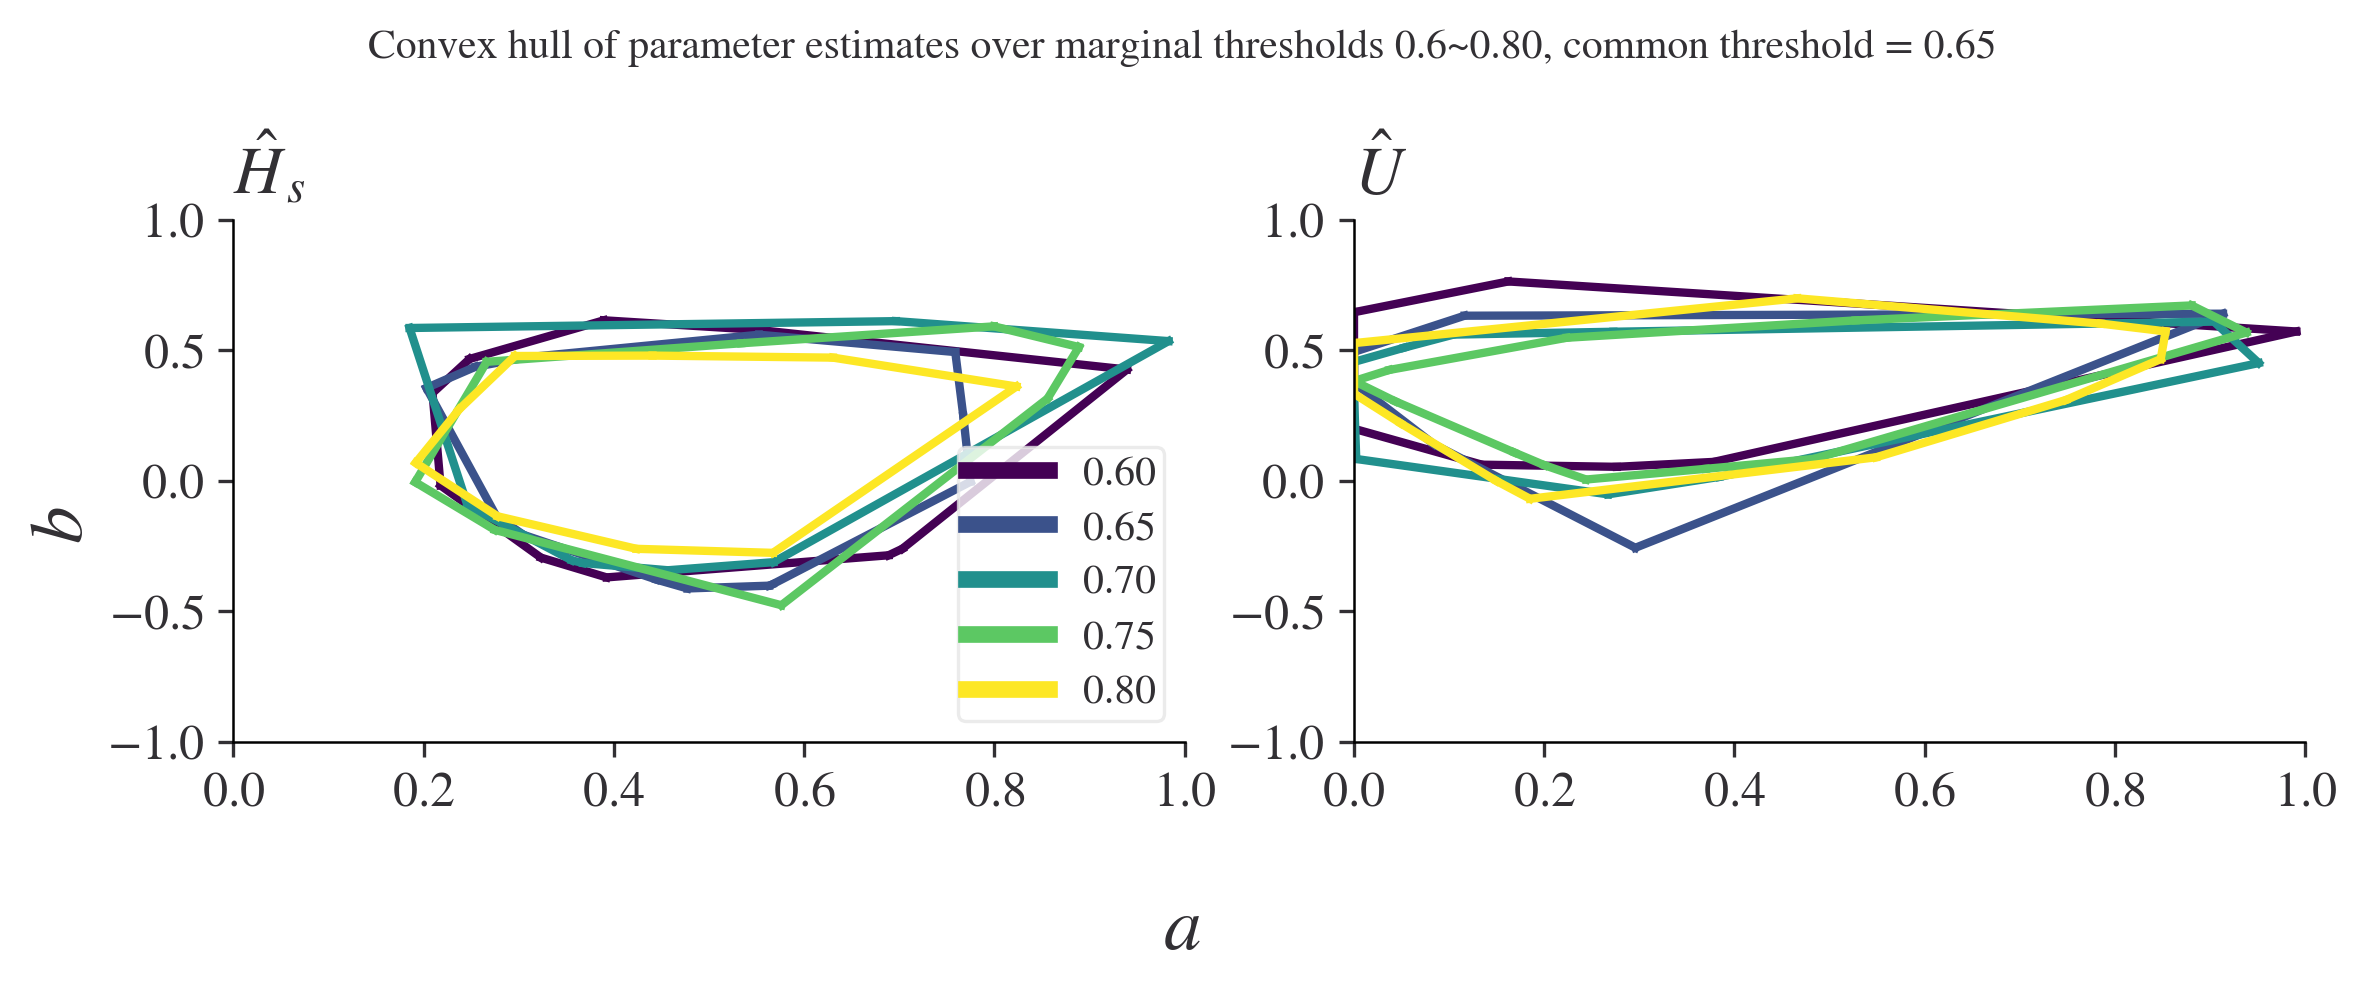

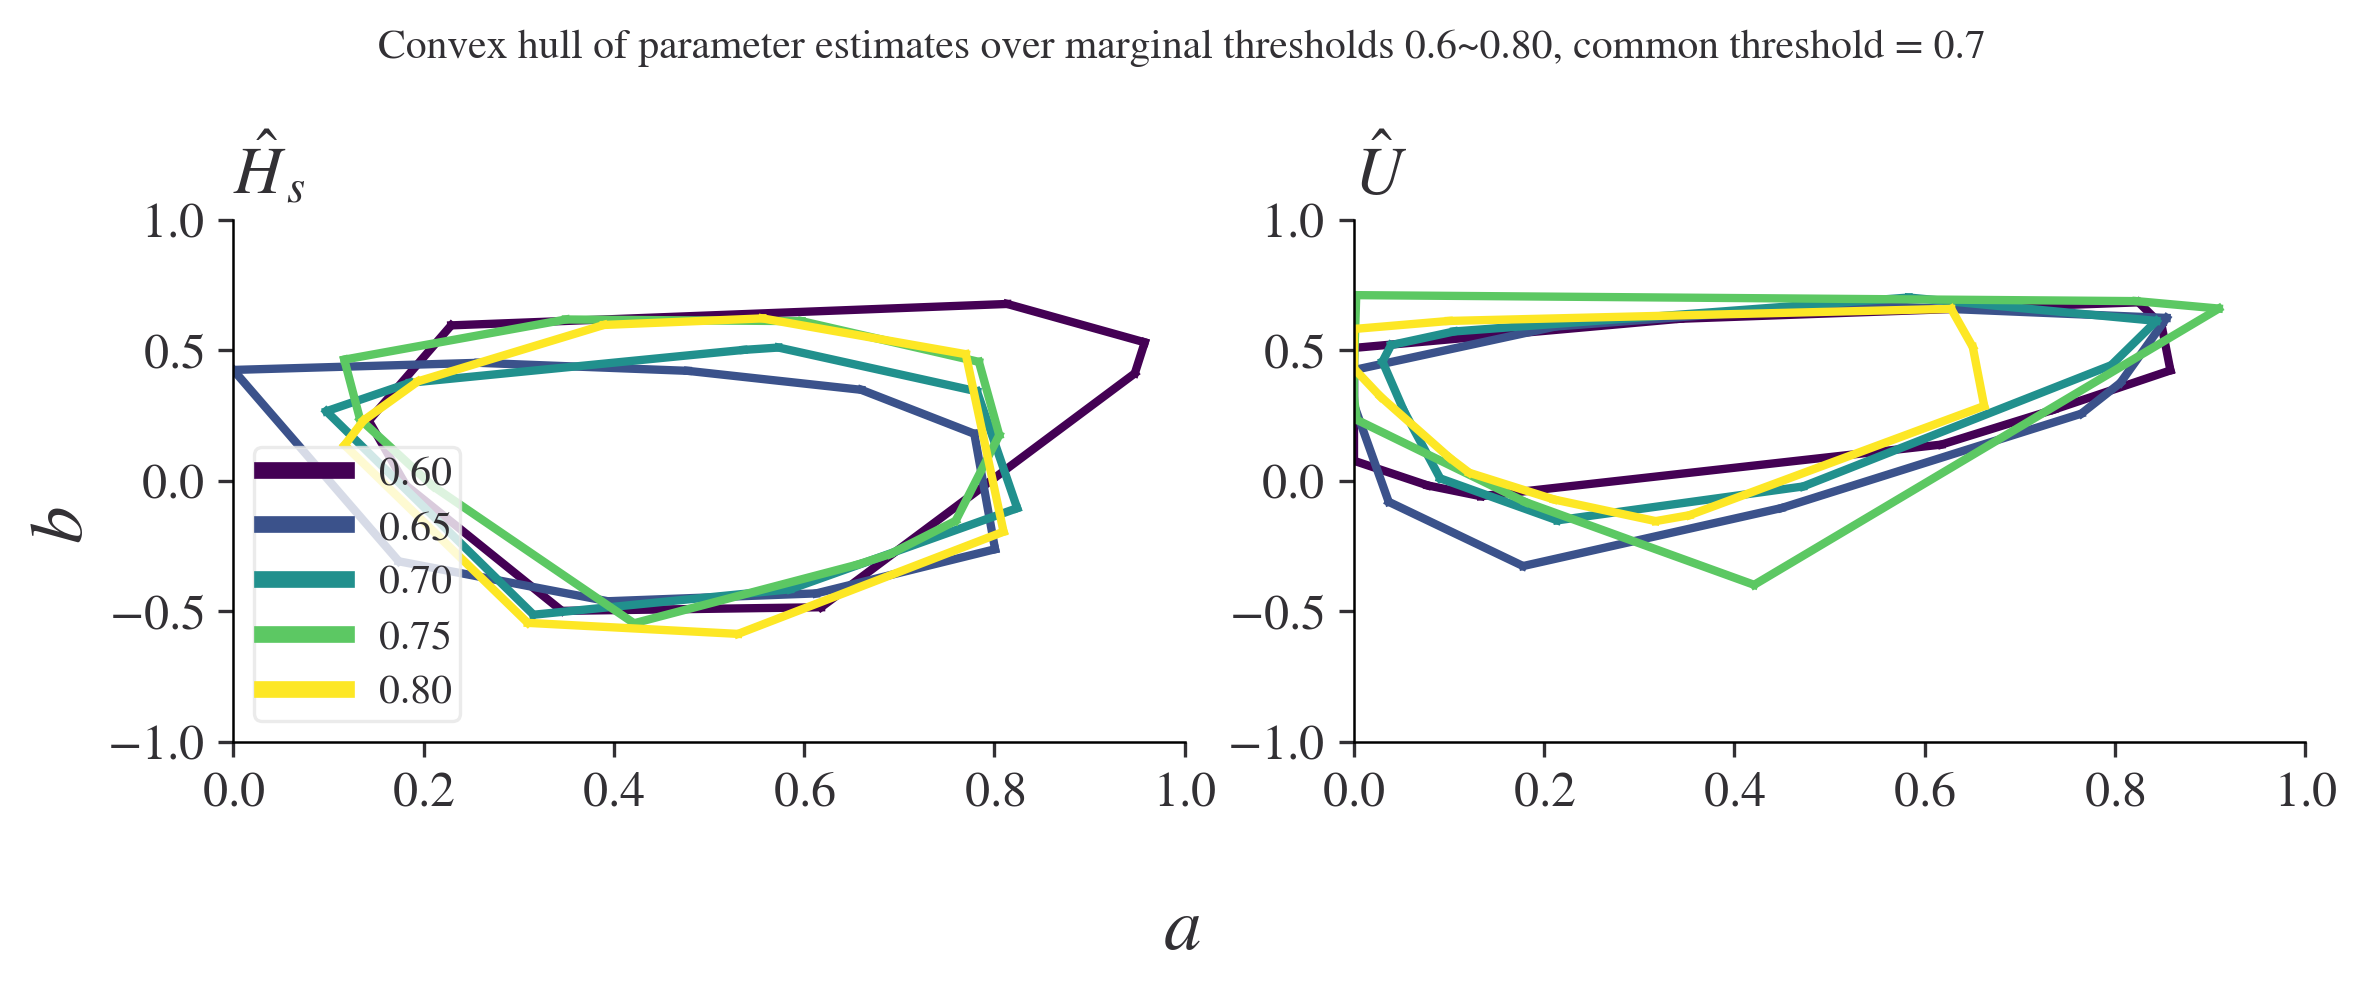

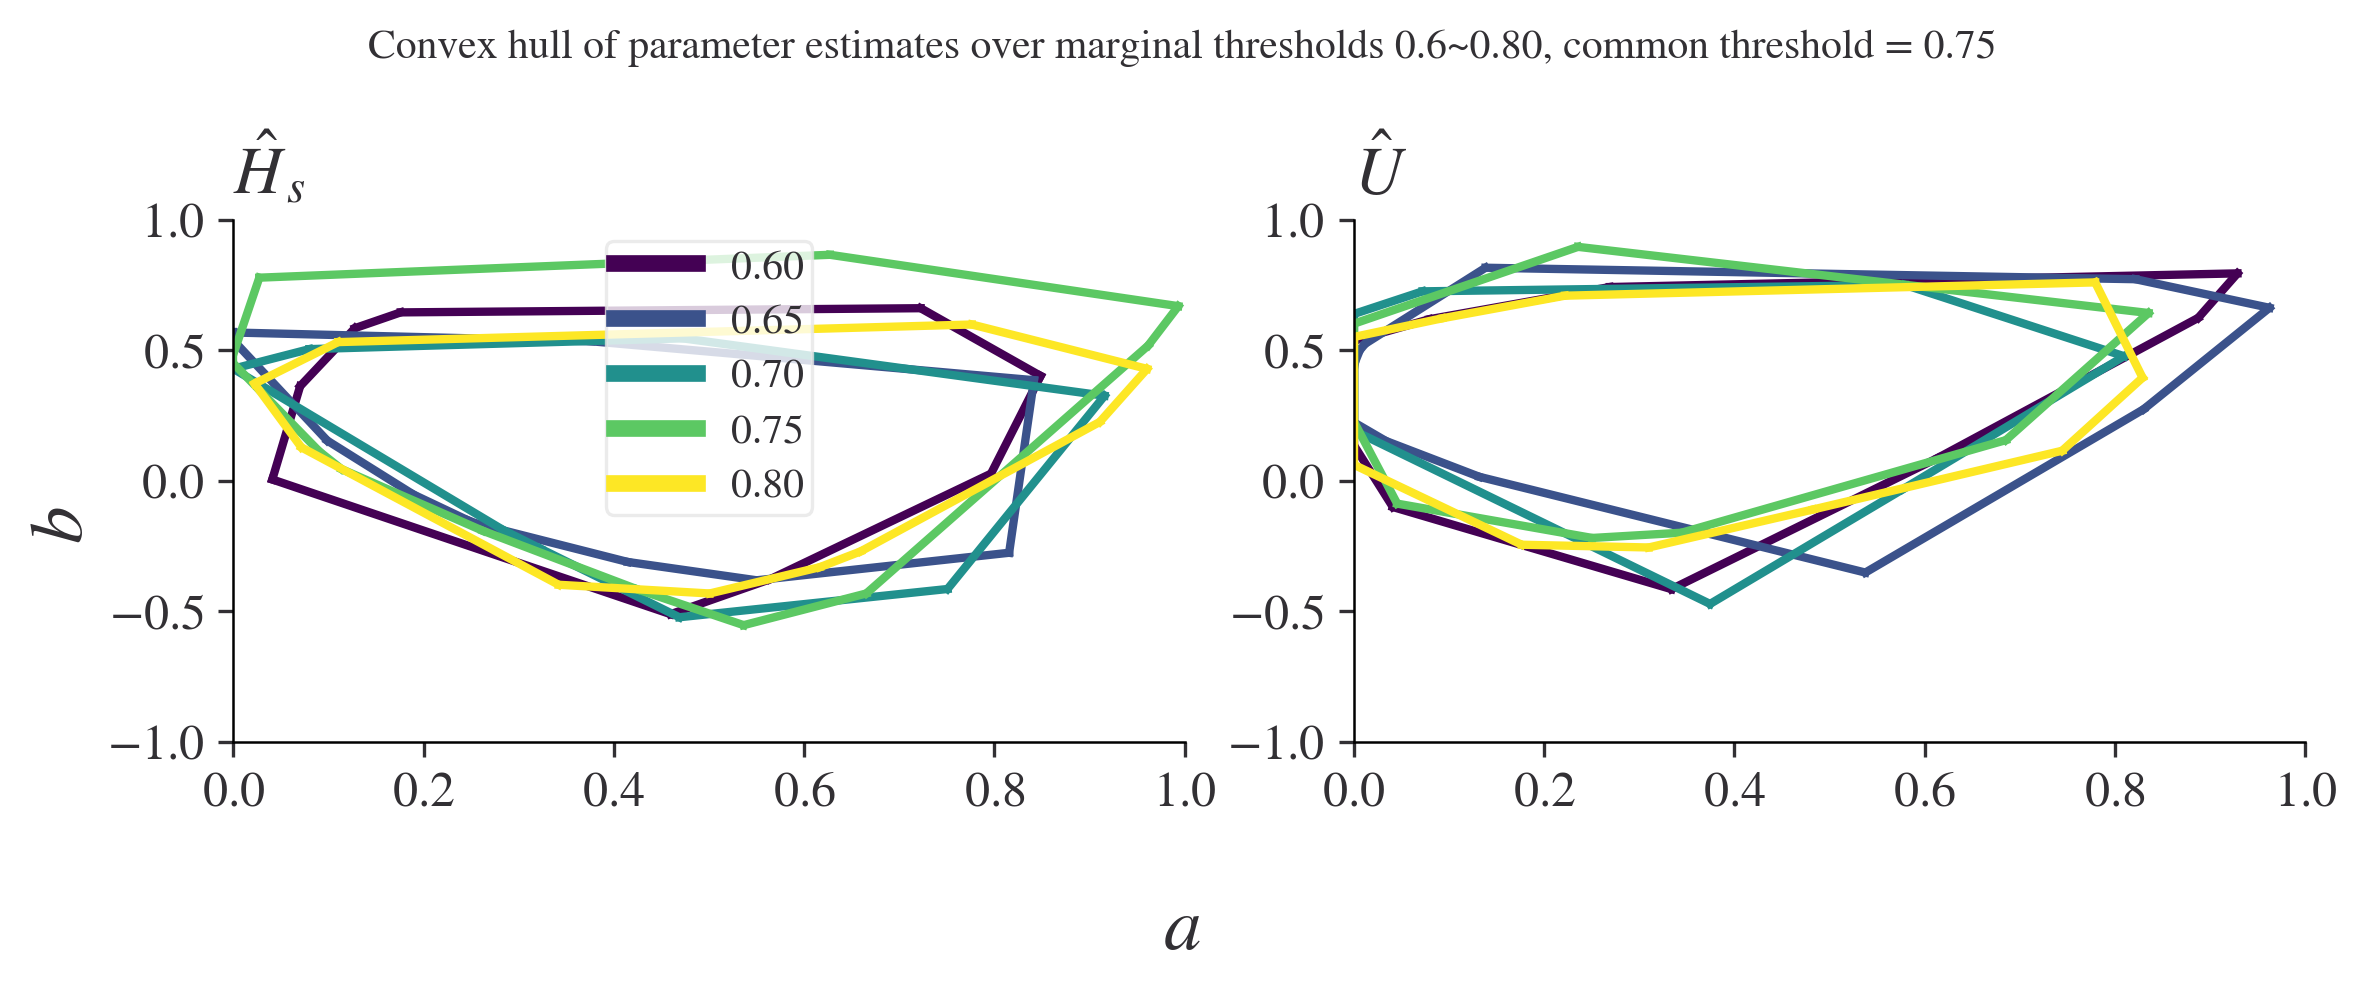

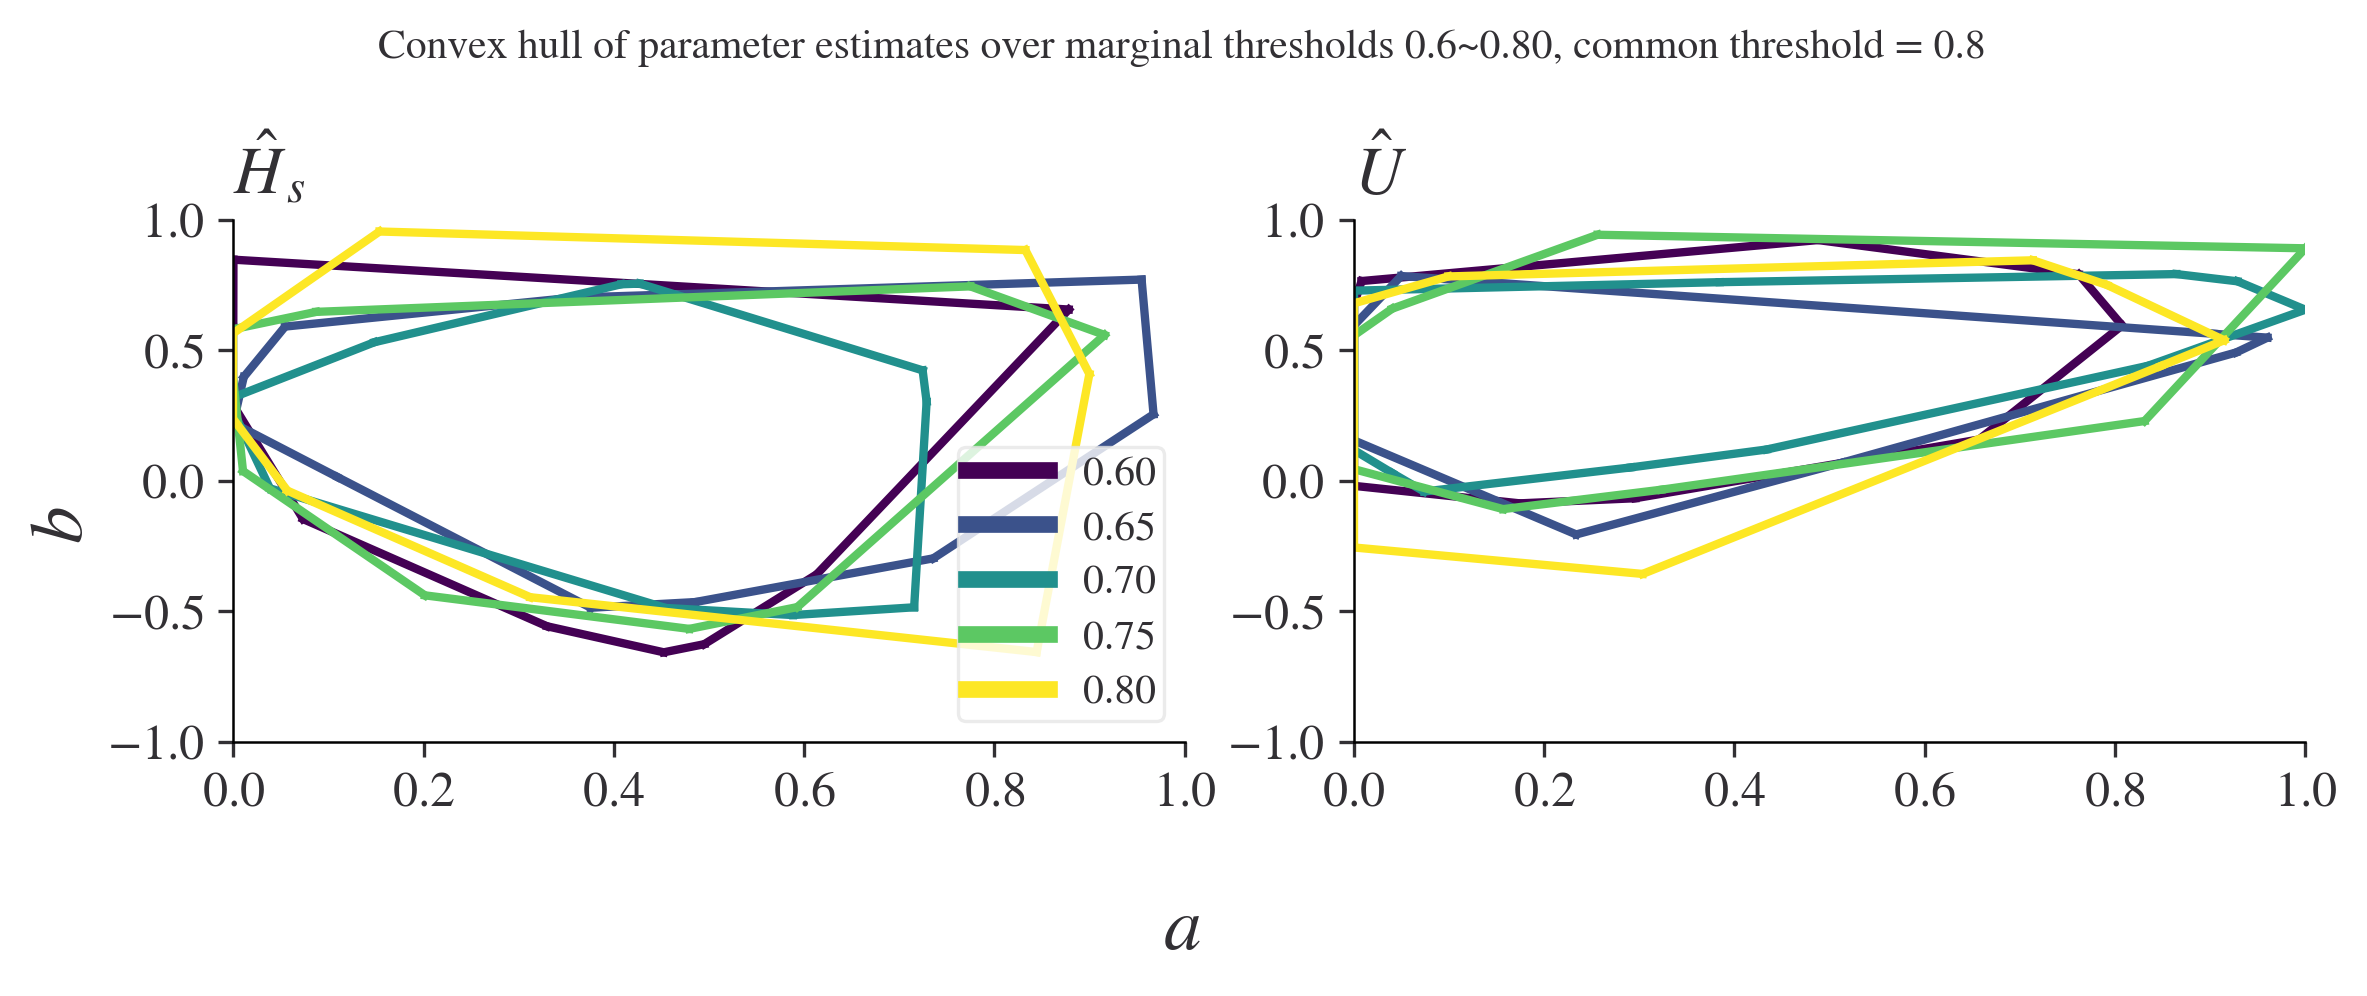

In [21]:
for idx in range(cl_arr.shape[1]):
  fig, ax = plt.subplots(1,2, figsize=(8, 3))
  fig.supxlabel("$a$")
  fig.supylabel("$b$")
  fig.suptitle(f"Convex hull of parameter estimates over marginal thresholds 0.6~0.80, common threshold = {cl_arr[0,idx].thr_pct_com}",size=10,y=1.05)
  fig.tight_layout()
  custom_lines = []
  thr_mar_list = []

  for cl in cl_arr[:, idx]:
    print(cl.thr_pct_mar, cl.thr_pct_com)
    thr_mar_list.append(cl.thr_pct_mar)
    thr_mar_norm = remap(cl.thr_pct_mar,0.6,0.80,0,1)
    custom_lines.append(Line2D([0], [0], color=viridis(thr_mar_norm), lw=4))
    for S in STM:
      vi=S.idx()
      ax[vi].set_xlim(0, 1)
      ax[vi].set_ylim(-1, 1)
      ax[vi].set_title(S.name_norm())
      points = np.array([cl.params_uc[vi,:,0],cl.params_uc[vi,:,1]]).T
      hull = ConvexHull(points)
      for simplex in hull.simplices:
        ax[vi].plot(points[simplex, 0], points[simplex, 1], c=viridis(thr_mar_norm))
  ax[0].legend(custom_lines, [f'{thr:.2f}'for thr in thr_mar_list])
  plt.savefig(dir_out/f"convex_hull_marginal_CM{cl_arr[0,idx].thr_pct_com*100:.2f}%.png", bbox_inches="tight")
  plt.savefig(dir_out/f"convex_hull_marginal_CM{cl_arr[0,idx].thr_pct_com*100:.2f}%.pdf", bbox_inches="tight")


# Dependency threshold choice

## Load data (only at one marginal threshold)

In [24]:
thr_pct_mar = 0.6

In [25]:
if path_notebook.exists() and not RECALC:
    pass
else:
    cl_list = []
    for i, path in enumerate(
        Path(f"./output/{region}/{rf}").glob(
            f"GP{round(thr_pct_mar*100)}%_CM*%_{N_subsample}subsamples/mstme_condition.dill"
        )
    ):
        with open(path, "rb") as f:
            cluster: MSTME = dill.load(f)
            cl_list.append(cluster)
            if i==0:
                tree = KDTree(cluster.latlon)
                grid_res = 10
                lat_list = np.linspace(cluster.area.min_lat, cluster.area.max_lat, grid_res)
                lon_list = np.linspace(cluster.area.min_lon, cluster.area.max_lon, grid_res)
                dist_list, pos_list = tree.query([[[lat, lon] for lat in lat_list] for lon in lon_list])
                pos_list = pos_list.flatten()
                pos_list = np.unique(pos_list)
            if not hasattr(cluster, "pval"):
                cluster.calc_kendall_tau()


## count

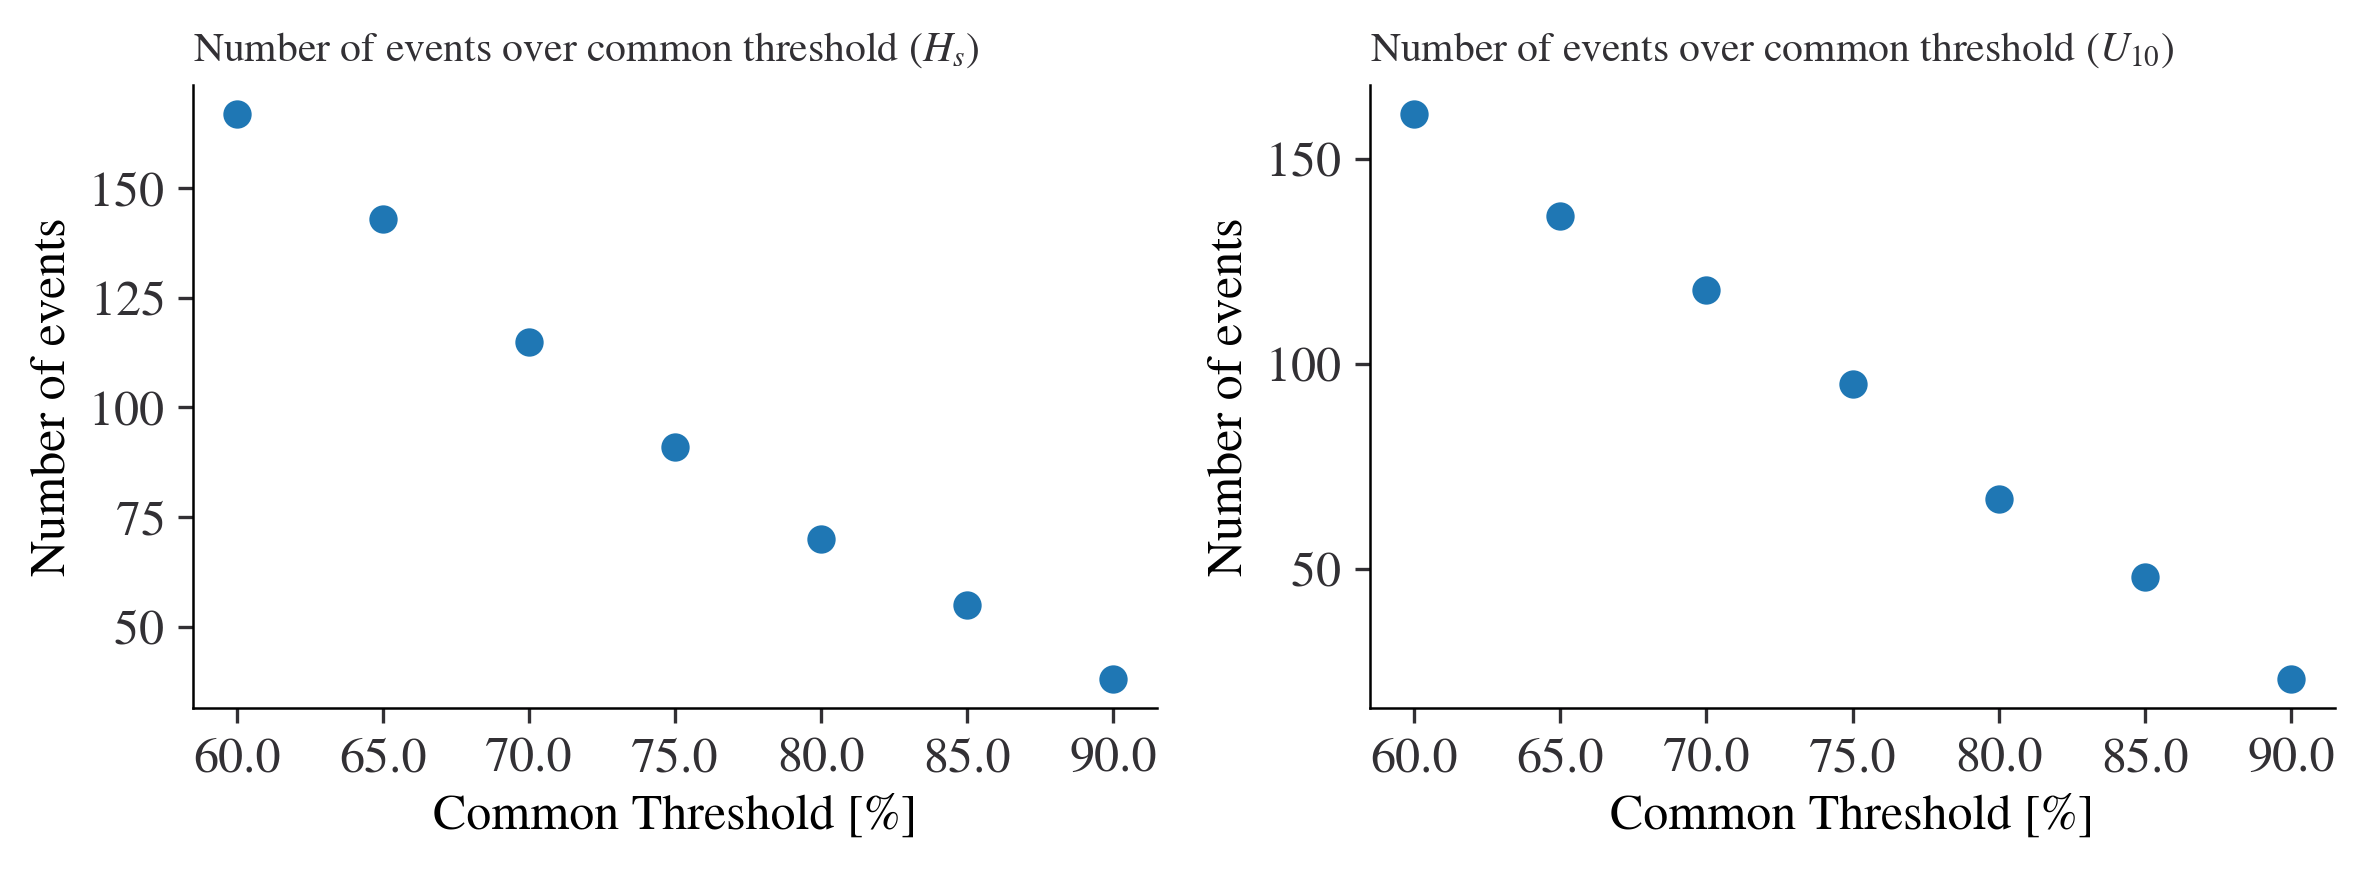

In [27]:
count = []
thr = []
for cl in cl_list:
    thr.append(cl.thr_pct_com*100) 
    count.append(np.count_nonzero(cl.is_e,axis=1))

count=np.array(count)

fig,ax= plt.subplots(1,2,figsize=(4*2,3))
for S in STM:
    vi = S.idx()
    ax[vi].set_title(f"Number of events over common threshold ({S.name()})",size=10)
    ax[vi].set_xlabel("Common Threshold [%]")
    ax[vi].set_ylabel("Number of events")
    ax[vi].set_xticks(thr, labels=thr)
    ax[vi].scatter(thr,count[:,vi])

        
fig.tight_layout()
plt.savefig(dir_out/f"number_of_events_GP{thr_pct_mar*100:.2f}%.png", bbox_inches="tight")
plt.savefig(dir_out/f"number_of_events_GP{thr_pct_mar*100:.2f}%.pdf", bbox_inches="tight")


## Convex hull

0.6 0.6
0.6 0.65
0.6 0.7
0.6 0.75
0.6 0.8


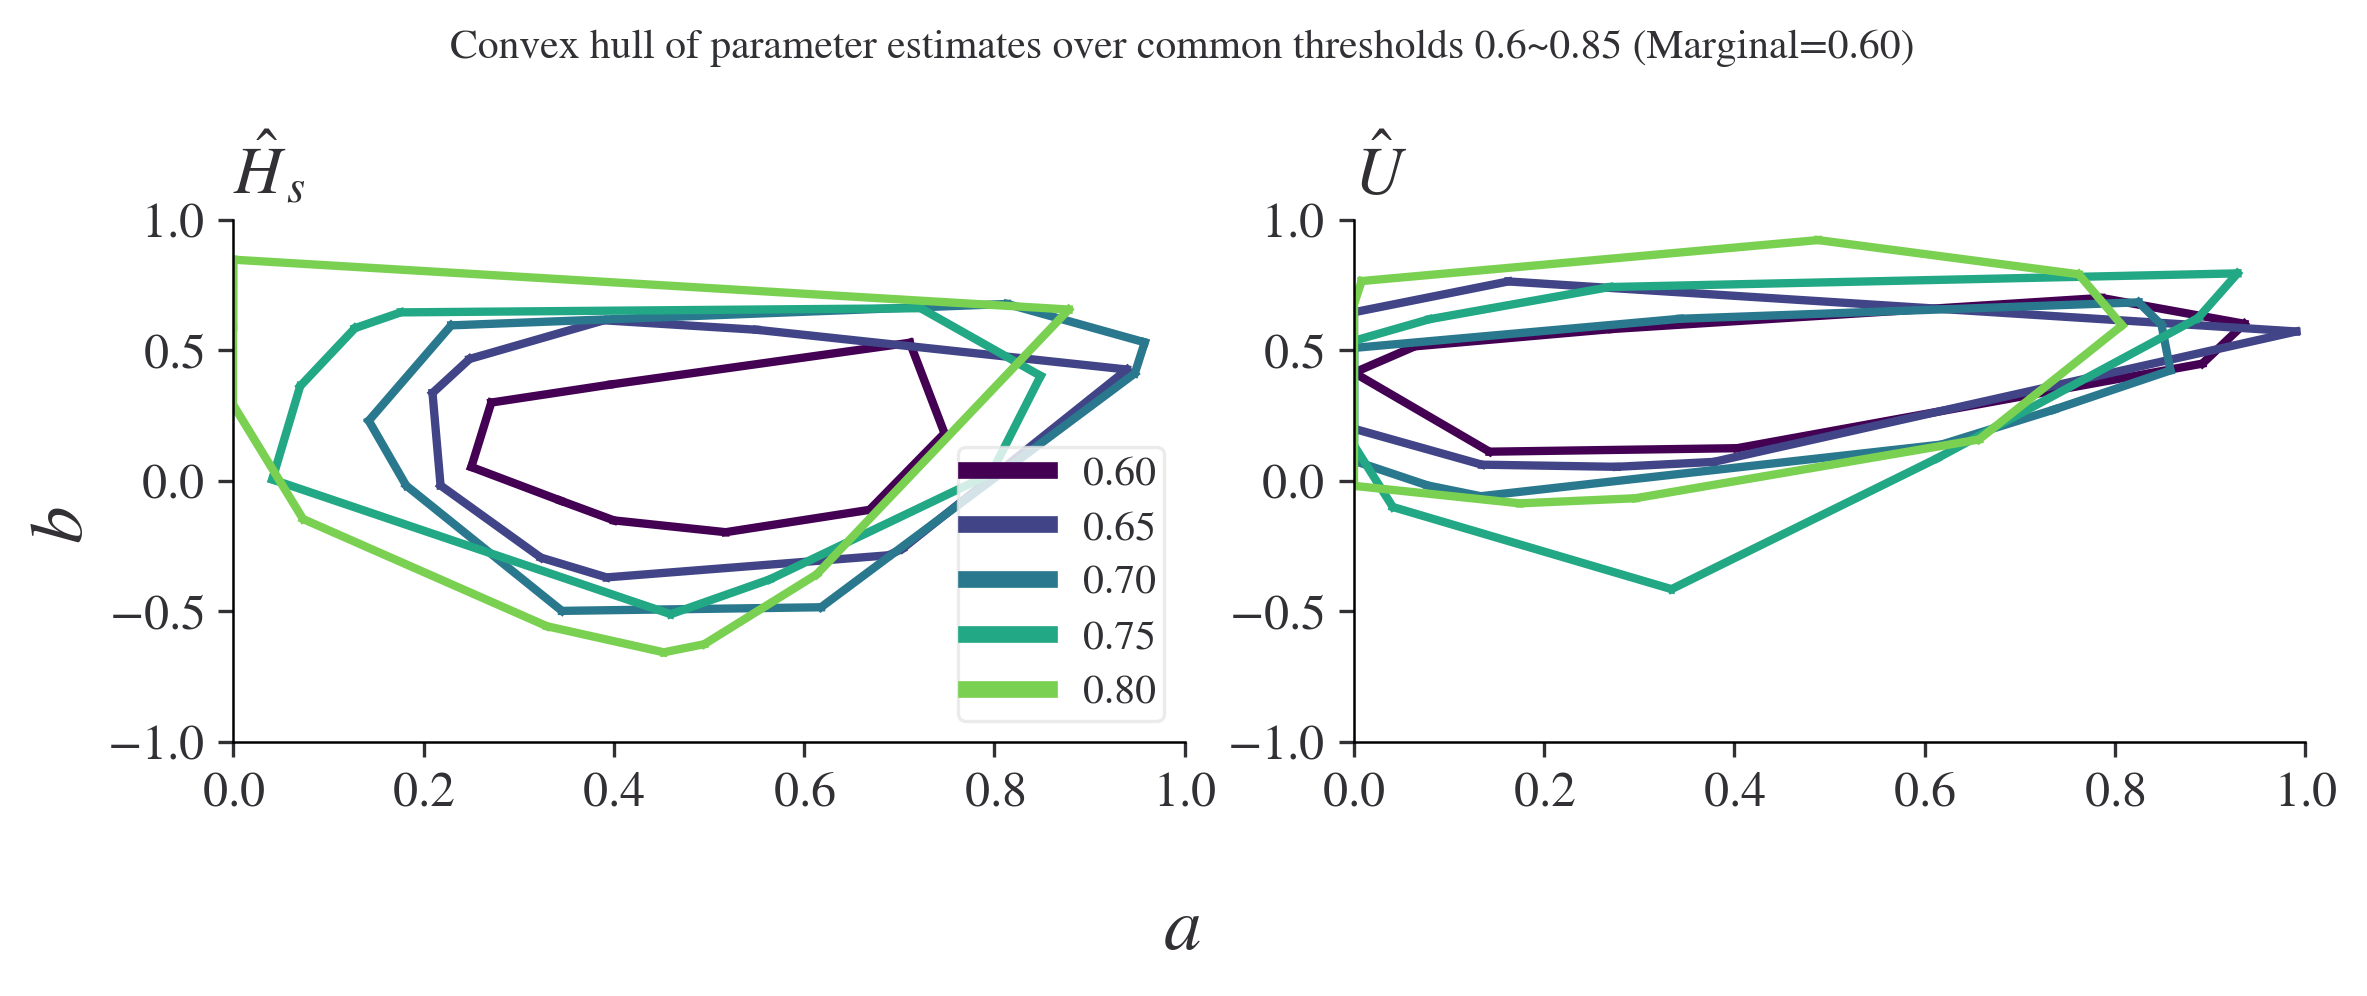

In [28]:
fig, ax = plt.subplots(1,2, figsize=(8, 3))
fig.supxlabel("$a$")
fig.supylabel("$b$")
fig.suptitle("Convex hull of parameter estimates over common thresholds 0.6~0.85 (Marginal=0.60)",size=10,y=1.05)
fig.tight_layout()

custom_lines = []
thr_com_list = []

for i,cl in enumerate(cl_arr[0,:]):
  print(cl.thr_pct_mar, cl.thr_pct_com)
  thr_com_list.append(cl.thr_pct_com)
  thr_com_norm = remap(cl.thr_pct_com,0.6,0.85,0,1)
  custom_lines.append(Line2D([0], [0], color=viridis(thr_com_norm), lw=4))
  for S in STM:
    vi=S.idx()
    ax[vi].set_xlim(0, 1)
    ax[vi].set_ylim(-1, 1)
    ax[vi].set_title(S.name_norm())
    points = np.array([cl.params_uc[vi,:,0],cl.params_uc[vi,:,1]]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
      ax[vi].plot(points[simplex, 0], points[simplex, 1], c=viridis(thr_com_norm))

ax[0].legend(custom_lines, [f'{thr:.2f}'for thr in thr_com_list])
plt.savefig(dir_out/f"convex_hull_conditional_GP{thr_pct_mar*100:.2f}%.png", bbox_inches="tight")
plt.savefig(dir_out/f"convex_hull_conditional_GP{thr_pct_mar*100:.2f}%.pdf", bbox_inches="tight")

## kt fail ratio

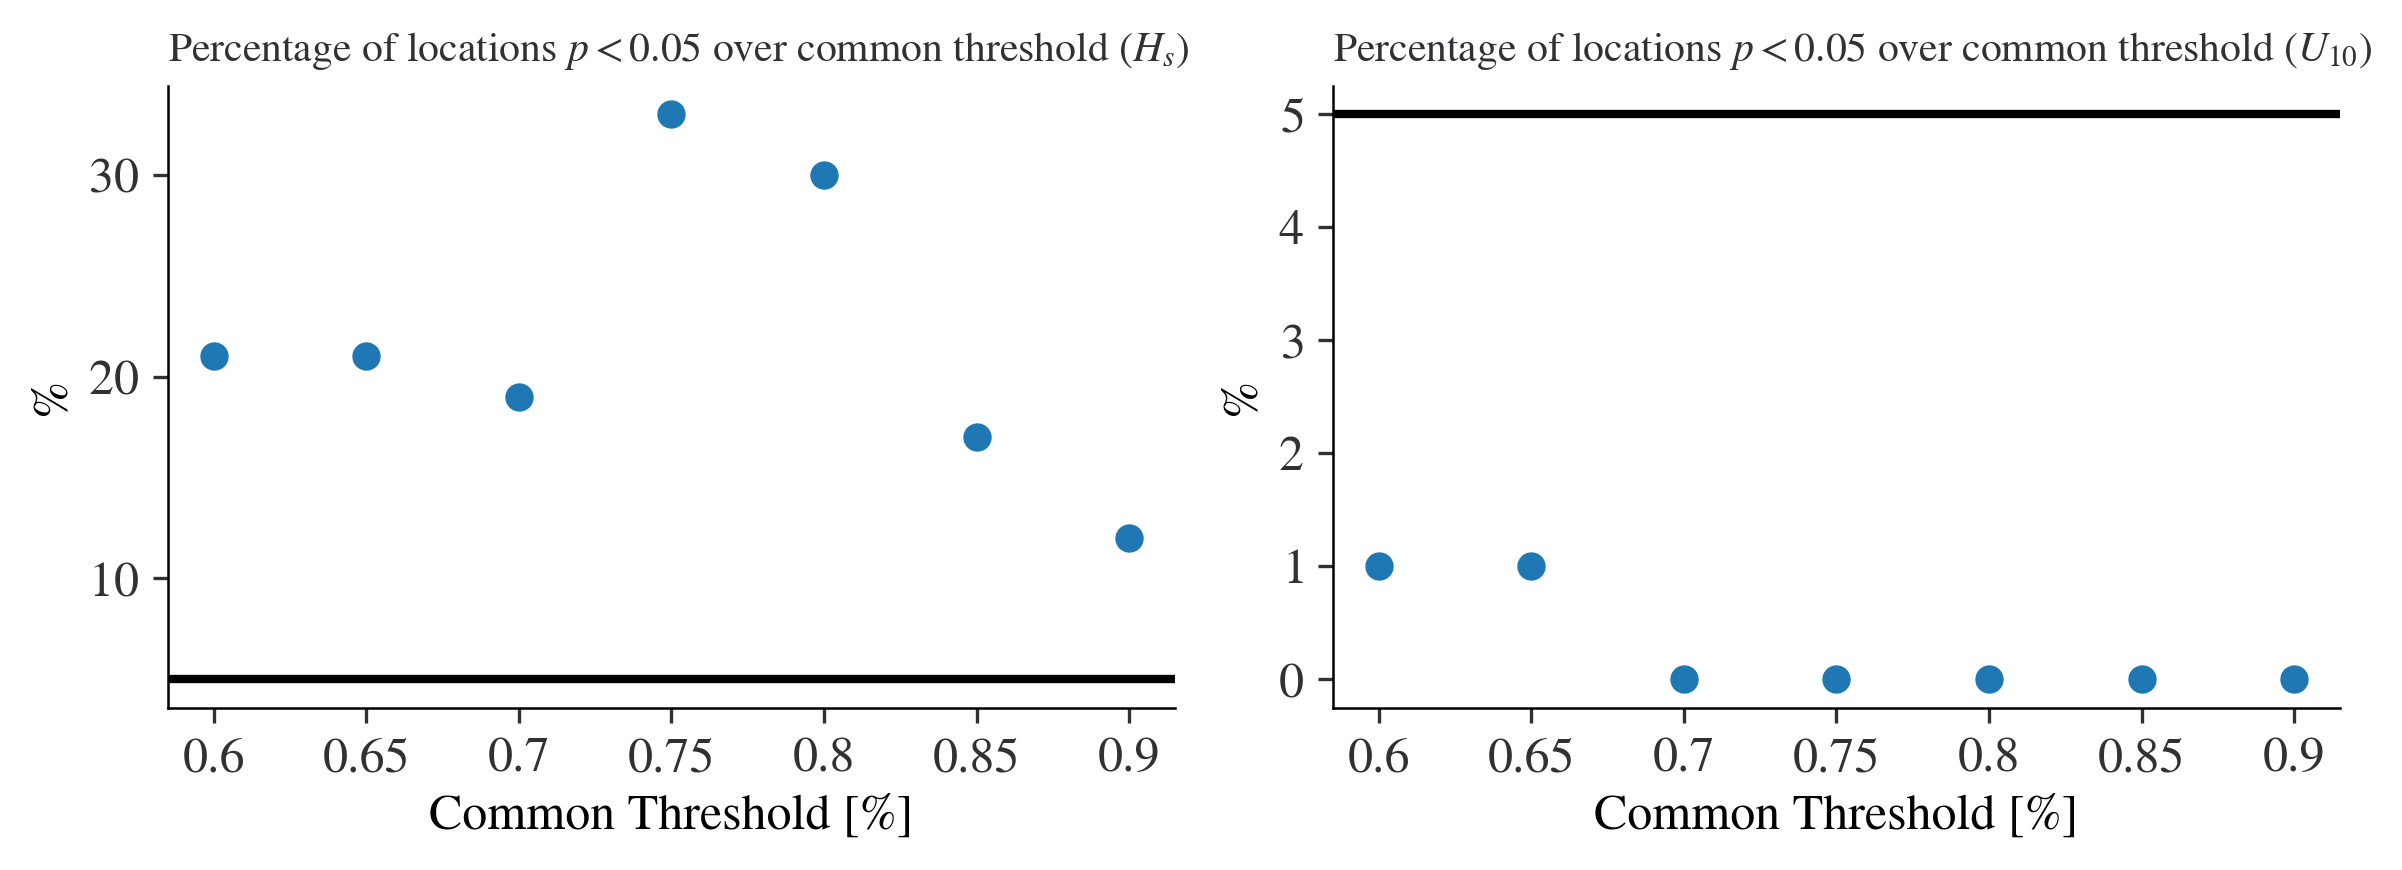

In [30]:
kt_fail_ratio = []
thr = []
for cl in cl_list:
    thr.append(cl.thr_pct_com)
    kt_fail_ratio.append(np.count_nonzero(cl.pval[:, :, pos_list] < 0.05, axis=2)
                    / pos_list.size)

kt_fail_ratio=np.array(kt_fail_ratio)

fig,ax= plt.subplots(1,2,figsize=(4*2,3))
for S in STM:
    vi = S.idx()
    ax[vi].set_title(f"Percentage of locations $p<0.05$ over common threshold ({S.name()})",size=10)
    ax[vi].set_xlabel("Common Threshold [%]")
    ax[vi].set_ylabel("%")
    ax[vi].set_xticks(thr, labels=thr)
    ax[vi].axhline(5,c='k',zorder=-1)
    ax[vi].scatter(thr,kt_fail_ratio[:,vi,vi]*100)

        
fig.tight_layout()
plt.savefig(dir_out/f"kt_fail_ratio_GP{thr_pct_mar*100:.2f}%.png", bbox_inches="tight")
plt.savefig(dir_out/f"kt_fail_ratio_GP{thr_pct_mar*100:.2f}%.pdf", bbox_inches="tight")

## shape param

<bound method Figure.tight_layout of <Figure size 1200x1200 with 1 Axes>>

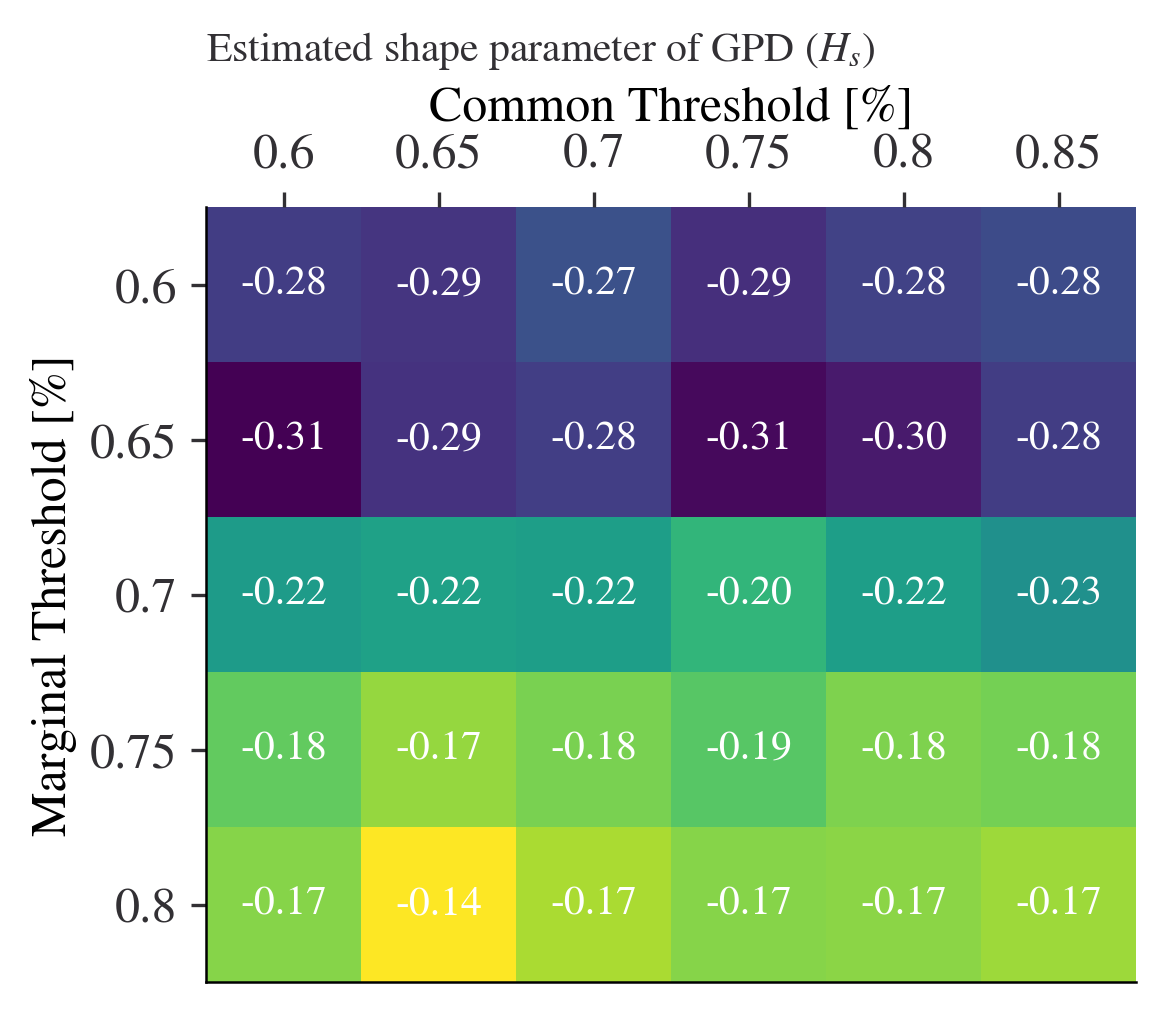

In [ ]:
# data = np.stack(df['shape_param'].values).reshape((5,6,2))[:,:,0]
# x=[0.60,0.65,0.70,0.75,0.80,0.85]
# y=[0.60,0.65,0.70,0.75,0.80]

# fig,ax= plt.subplots(1,1,figsize=(4,4))
# ax.set_title("Estimated shape parameter of GPD ($H_s$)",size=10)
# ax.set_xlabel("Common Threshold [%]")
# ax.set_ylabel("Marginal Threshold [%]")
# ax.set_xticks(np.arange(len(x)), labels=x)
# ax.set_yticks(np.arange(len(y)), labels=y)
# ax.tick_params(top=True, bottom=False,
#                    labeltop=True, labelbottom=False)
# ax.xaxis.set_label_position('top')
# im=ax.imshow(
#       data,
#       origin='upper',
#     )

# for i in range(len(x)):
#     for j in range(len(y)):
#         text = ax.text(i, j, f"{data[j, i]:.2f}",
#                        ha="center", va="center", color="w")
        
# fig.tight_layout

# Dump

In [16]:
with open(path_notebook,'wb') as f:
    dill.dump_session(f)

# stuff

In [ ]:
def draw_rv(mstme:MSTME,tm_MSTME_ss,**kwargs):
    grid_res = 11
    mstme = mstme
    area = mstme.area
    lat_list = np.linspace(area.min_lat, area.max_lat, grid_res)
    lon_list = np.linspace(area.min_lon, area.max_lon, grid_res)
    dist_list, pos_list = mstme.tree.query(
        [[[lat, lon] for lat in lat_list] for lon in lon_list]
    )
    pos_list = pos_list.flatten()
    tm_MSTME_ss_norm = np.empty(tm_MSTME_ss.shape[:3]+(len(pos_list),))  # (ss,v,e,n)
    tm_original = mstme.tm  # (v,e,n)
    for S in STM:
        vi = S.idx()
        tm_MSTME_ss_norm[:, vi, :, :] = mstme.ndist.ppf(
            mstme.mix_dist[vi].cdf(tm_MSTME_ss[:, vi, :][:,:,pos_list])
        )
    # bi, ni, vi, ei
    return_period = kwargs.get("return_period")

    N_subsample = tm_MSTME_ss_norm.shape[0]
    _num_events_sample = tm_MSTME_ss_norm.shape[2]
    _exceedance_prob = 1 - mstme.thr_pct_com

    l_array_MSTME = []
    l_array_original = []
    for i,ni in enumerate(pos_list):
        print(i)
        # Sample count over threshold
        _count_sample = round(
            _num_events_sample
            / (return_period * mstme.occur_freq * _exceedance_prob)
        )
        _ic_original = []
        _num_events_original = tm_original.shape[1]
        _count_original = round(
            _num_events_original / (return_period * mstme.occur_freq)
        )

        # Bootstraps
        ic_MSTME = []
        # ic_PWE = []
        for ssi in range(N_subsample):
            _ic_MSTME = grapher._search_isocontour(
                tm_MSTME_ss_norm[ssi, :, :, i], _count_sample
            )
            ic_MSTME.append(_ic_MSTME)

        l_array_MSTME.append(grapher._get_interp_band_diag(ic_MSTME))

        # Original
        _ic_original = grapher._search_isocontour(
            tm_original[:, :, ni], _count_original
        )
        l_array_original.append(grapher._get_interp_band_diag(_ic_original))
    l_array_MSTME = np.array(l_array_MSTME)
    l_array_original = np.array(l_array_original)

    bias_MSTME = l_array_MSTME - l_array_original
    var_MSTME = np.var(l_array_MSTME, axis=1)
    #########################################################
    fig, ax = plt.subplots(
        1,
        2,
        figsize=(8 * 2, 6 * 2),
        facecolor="white",
    )
    data = [bias_MSTME,var_MSTME]
    for i in range(2):
        ax[i].set_xlim(area.min_lon, area.max_lon)
        ax[i].set_ylim(area.min_lat, area.max_lat)
        ax[i].scatter(
            mstme.latlon[pos_list, 1],
            mstme.latlon[pos_list, 0],
            c=data[i],
        )

In [ ]:
stm_min = [0, 0]
stm_max = [30, 80]
grid_res = 10
mstme = cl_arr[0, 0]
area = mstme.area
lat_list = np.linspace(area.min_lat, area.max_lat, grid_res)
lon_list = np.linspace(area.min_lon, area.max_lon, grid_res)
dist_list, pos_list = mstme.tree.query(
    [[[lat, lon] for lat in lat_list] for lon in lon_list]
)
pos_list = pos_list.flatten()

tm_MSTME_ss_norm = np.empty(tm_MSTME_ss.shape[:3] + (len(pos_list),))  # (ss,v,e,n)
tm_original = mstme.tm  # (v,e,n)
tm_original_norm = np.empty(tm_original.shape[:2] + (len(pos_list),))  # (ss,v,e,n)
for S in STM:
    vi = S.idx()
    tm_MSTME_ss_norm[:, vi, :, :] = np.clip(mstme.ndist.ppf(
        mstme.mix_dist[vi].cdf(tm_MSTME_ss[:, vi, :][:, :, pos_list])
    ),-10,10)
    tm_original_norm[vi, :, :] = np.clip(mstme.ndist.ppf(
        mstme.mix_dist[vi].cdf(tm_original[vi, :, pos_list])
    ),-10,10)
# bi, ni, vi, ei
# return_period = kwargs.get("return_period")
return_period = 100

N_subsample = tm_MSTME_ss_norm.shape[0]
_num_events_sample = tm_MSTME_ss_norm.shape[2]

# N_subsample = tm_MSTME_ss.shape[0]
# _num_events_sample = tm_MSTME_ss.shape[2]
_exceedance_prob = 1 - mstme.thr_pct_com

l_array_MSTME = []
l_array_original = []
for i, ni in enumerate(pos_list):
    # Sample count over threshold
    _count_sample = round(
        _num_events_sample / (return_period * mstme.occur_freq * _exceedance_prob)
    )
    _num_events_original = tm_original.shape[1]
    _count_original = round(_num_events_original / (return_period * mstme.occur_freq))

    # Bootstraps
    ic_MSTME = []
    # ic_PWE = []
    for ssi in range(N_subsample):
        _ic_MSTME = grapher._search_isocontour(
            tm_MSTME_ss_norm[ssi, :, :, i], _count_sample
        )
        # _ic_MSTME = grapher._search_isocontour(
        #     tm_MSTME_ss_norm[ssi, :, :, ni], _count_sample
        # )
        ic_MSTME.append(_ic_MSTME)

    # l_array_MSTME.append(grapher._get_interp_band_diag(ic_MSTME,scale=stm_max[1] / stm_max[0]))
    l_array_MSTME.append(grapher._get_interp_band_diag(ic_MSTME, scale=1))

    # Original
    ic_original = grapher._search_isocontour(tm_original_norm[:, :, i], _count_original)
    # ic_original = grapher._search_isocontour(
    #     tm_original[:, :, ni], _count_original
    # )
    l_array_original.append(grapher._get_interp_band_diag([ic_original], scale=1))
    # l_array_original.append(grapher._get_interp_band_diag([ic_original],scale=stm_max[1] / stm_max[0]))
l_array_MSTME = np.array(l_array_MSTME)
l_array_original = np.array(l_array_original)

bias_MSTME = np.mean(l_array_MSTME - l_array_original, axis=1)
var_MSTME = np.var(l_array_MSTME, axis=1)

In [ ]:
from shapely.geometry import LineString, MultiLineString, MultiPoint, Point


In [ ]:
def get_interp(contours,scale):
    a = 1
    l0 = LineString([(-100, a * -100), (100, a * 100)])
    l_array = []
    for i,ct in enumerate(contours):
        l1 = LineString(ct.T)
        p = l0.intersection(l1)
        l_array.append(p.distance(Point(0,0)))
    return l_array

In [ ]:
bias_MSTME = np.mean((l_array_MSTME - l_array_original),axis=1)
bias_MSTME_pct = np.mean((l_array_MSTME/l_array_original-1),axis=1)
bias_MSTME_pct.shape

(100,)

(array([ 1.,  2., 13., 19., 18., 18., 13., 10.,  4.,  2.]),
 array([-0.68759805, -0.50020044, -0.31280283, -0.12540521,  0.0619924 ,
         0.24939001,  0.43678762,  0.62418523,  0.81158285,  0.99898046,
         1.18637807]),
 <BarContainer object of 10 artists>)

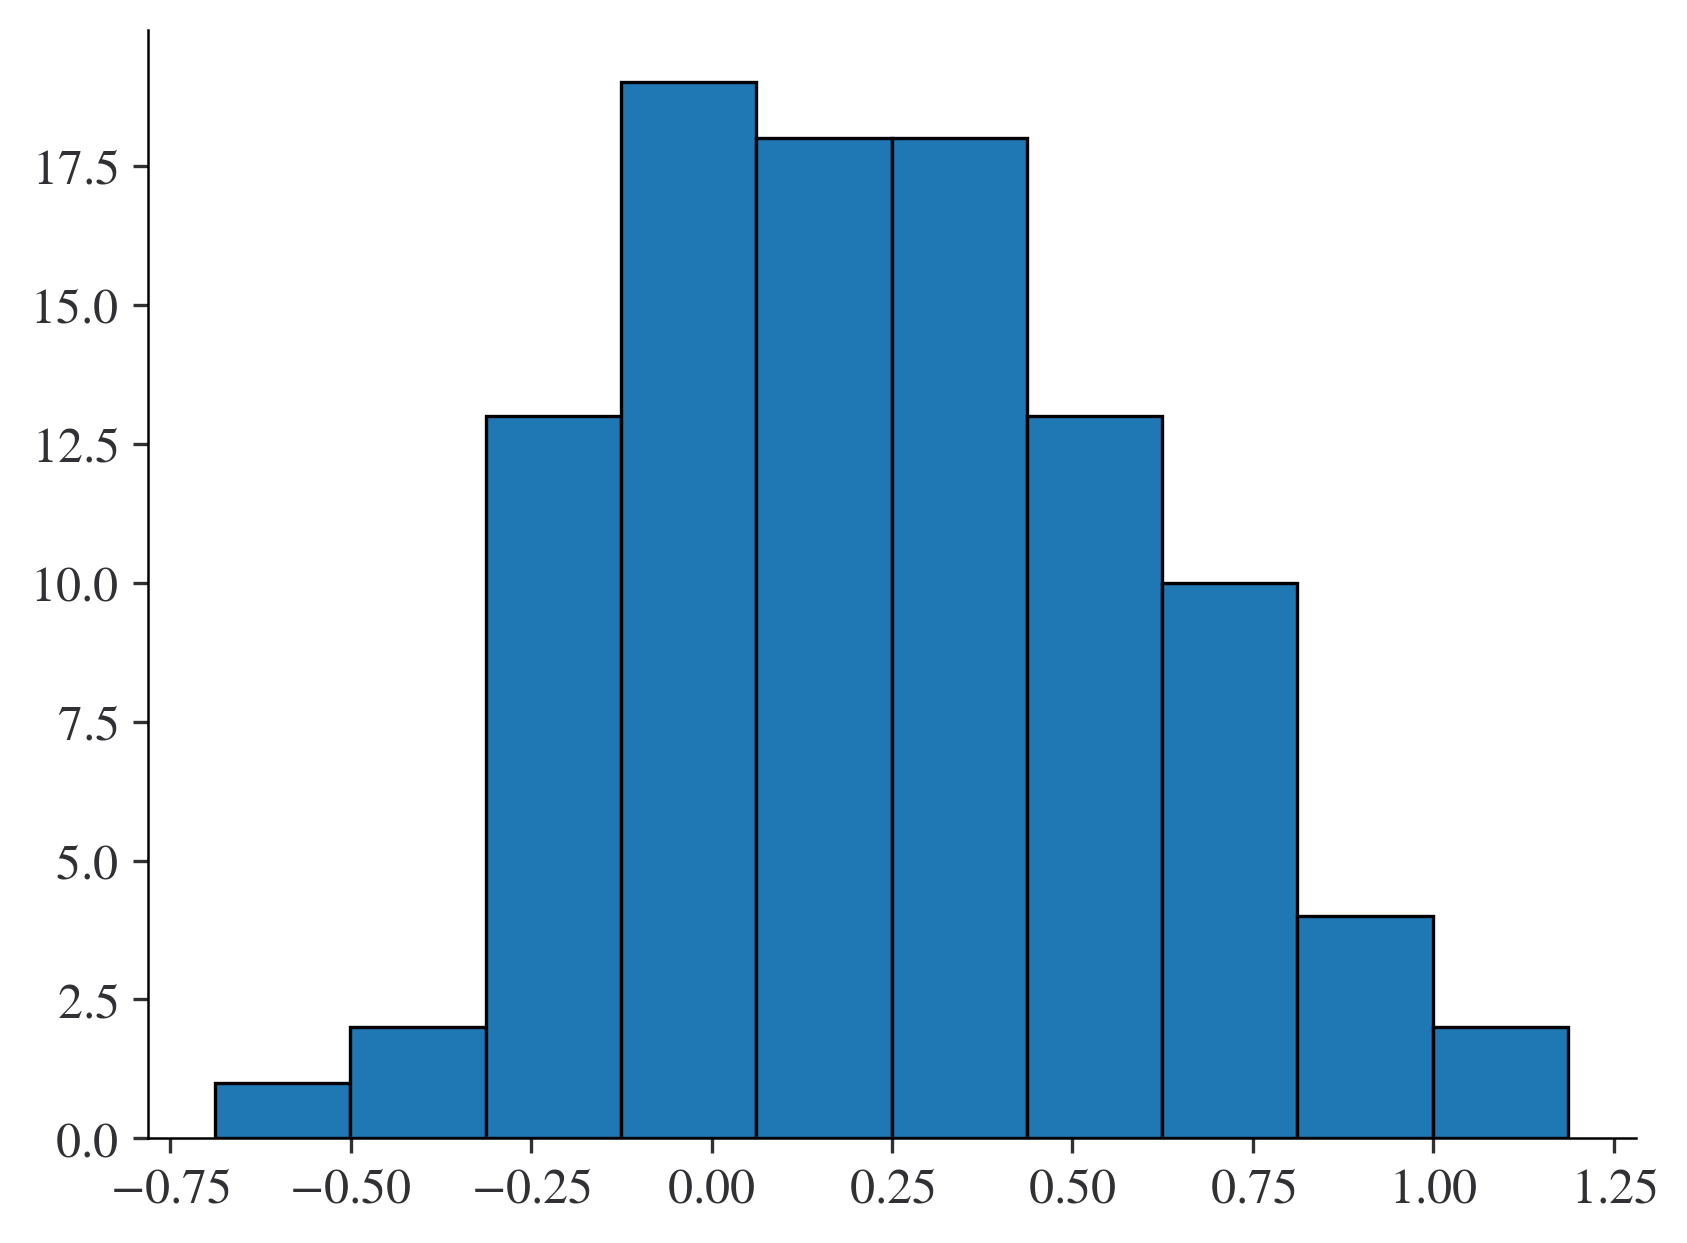

In [ ]:
plt.hist(l_array_MSTME[0]-l_array_original[0])

In [ ]:
i=10
MSTME_pctile = []
for i in range(len(l_array_MSTME)):
  pctile = ECDF(l_array_MSTME[i])(l_array_original[i])[0]
  MSTME_pctile.append(pctile)
# plt.hist(l_array_MSTME[i])
# plt.axvline(l_array_original[i])

In [ ]:

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

Text(0.0, 1.0, 'Visual example of how bias/variance is being calculated')

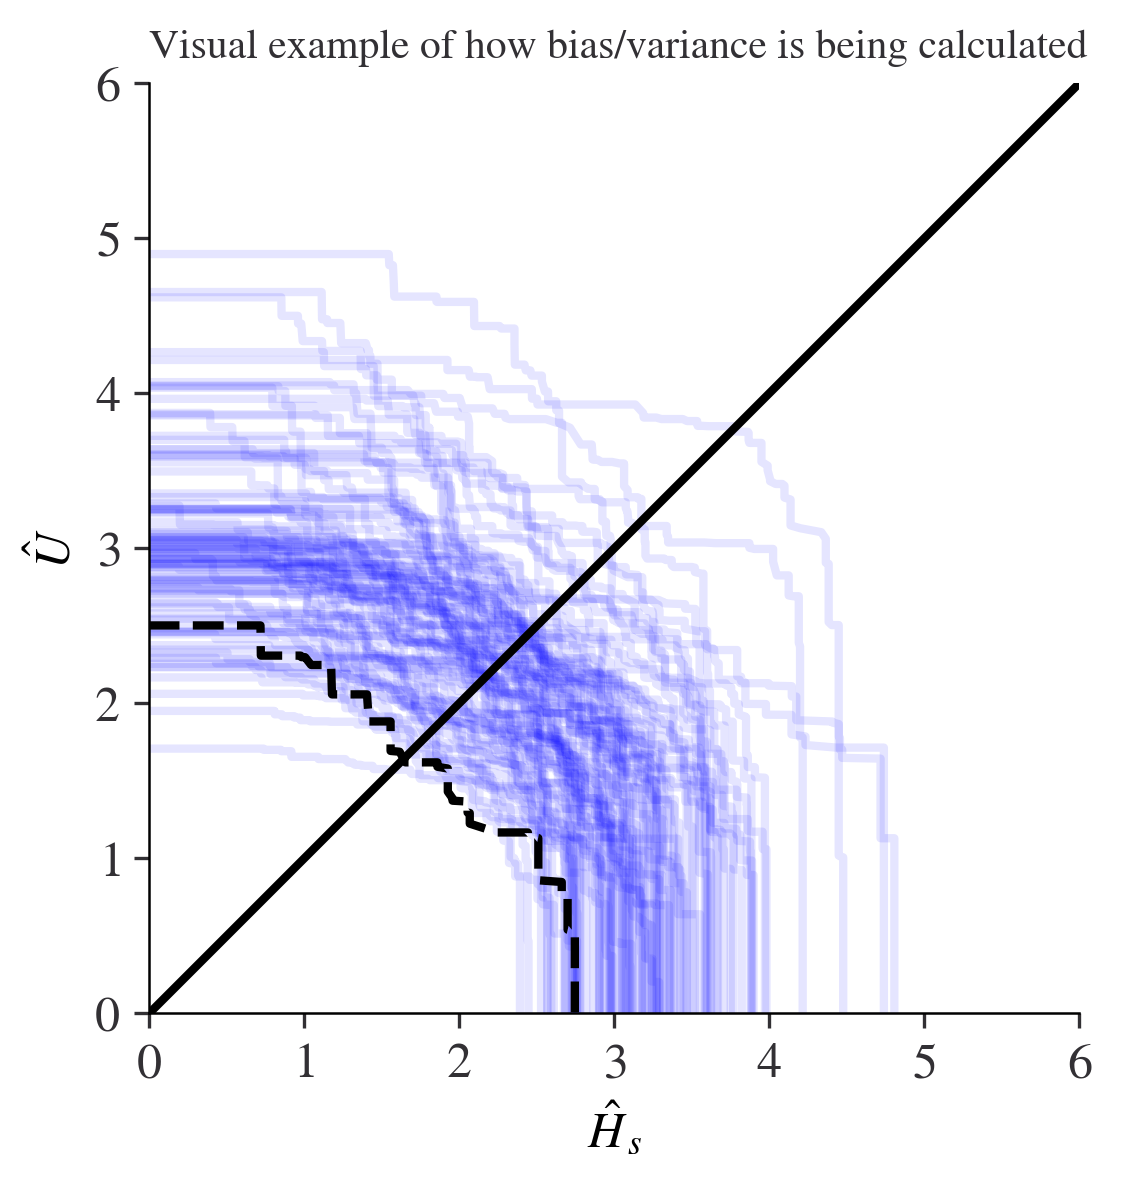

In [ ]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(4 , 6),
    facecolor="white",
)
ax.set_xlim(0,6)
ax.set_ylim(0,6)
ax.set_aspect('equal')
for ct in ic_MSTME:
    ax.plot(ct[0],ct[1],c='blue',alpha=0.1)
ax.plot([-10,10],[-10,10],c='black')
ax.plot(ic_original[0],ic_original[1],c='k',linestyle='--')
ax.set_xlabel(STM.H.name_norm())
ax.set_ylabel(STM.U.name_norm())
ax.set_title("Visual example of how bias/variance is being calculated",size=10)

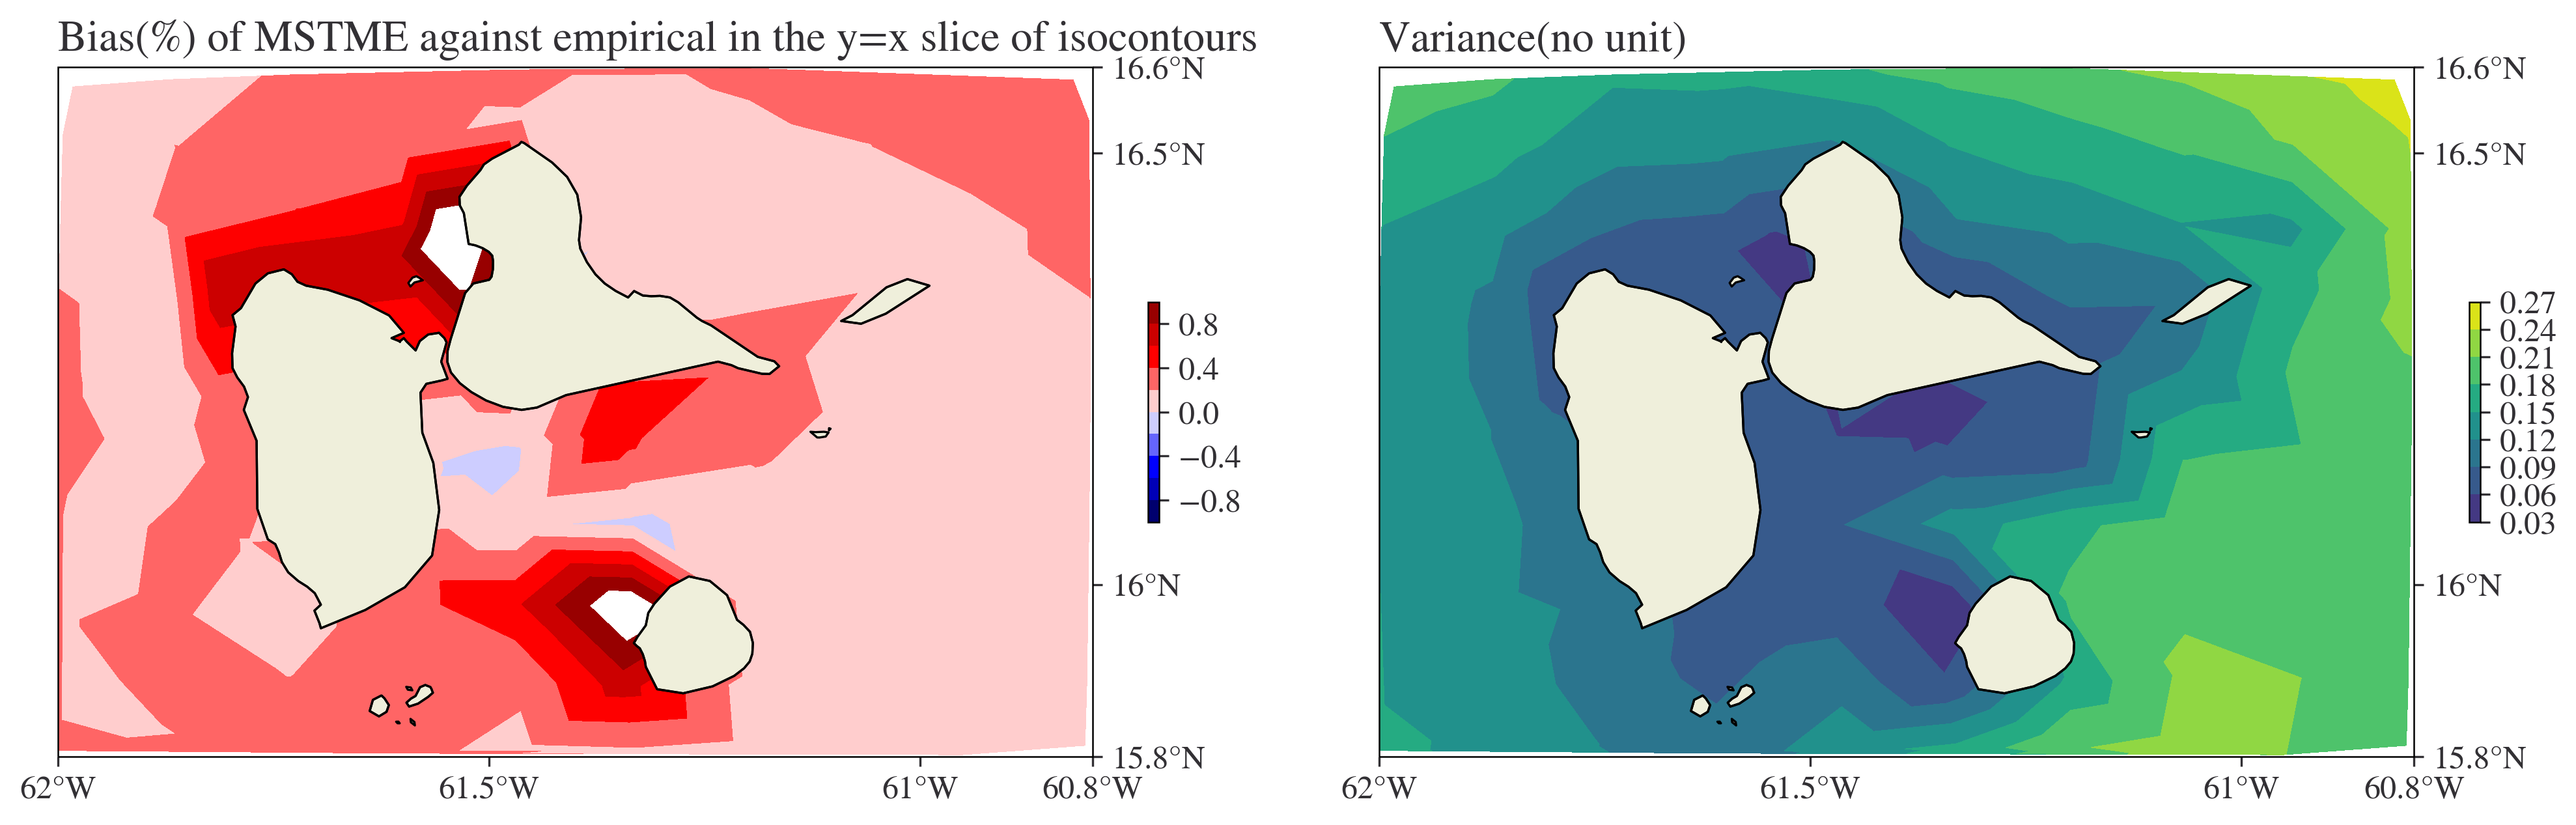

In [ ]:
fig, ax = plt.subplots(
    1,
    2,
    figsize=(8 * 2, 6 * 2),
    facecolor="white",
    subplot_kw={"projection": ccrs.PlateCarree()},
)
ax[0].set_title(f"Bias(%) of MSTME against empirical in the y=x slice of isocontours")
ax[0].set_xlim(area.min_lon, area.max_lon)
ax[0].set_ylim(area.min_lat, area.max_lat)
im0 = ax[0].tricontourf(
  mstme.latlon[pos_list, 1],
  mstme.latlon[pos_list, 0],
  # bias_MSTME,
  bias_MSTME_pct,
  # MSTME_pctile,
  cmap="seismic",
  levels=np.linspace(-1,1,11),
  # vmax=1,
  # vmin=0,
  zorder=-99,
)
ax[0] = grapher.custom_map(ax[0],cluster.area)

ax[1].set_title(f"Variance(no unit)")
ax[1].set_xlim(area.min_lon, area.max_lon)
ax[1].set_ylim(area.min_lat, area.max_lat)
im1 = ax[1].tricontourf(
  mstme.latlon[pos_list, 1],
  mstme.latlon[pos_list, 0],
  var_MSTME,
  vmin=0,
  zorder=-99,
)
ax[1] = grapher.custom_map(ax[1],cluster.area)
# fig.tight_layout()
# add_colorbar(im0)
plt.colorbar(im0,ax=ax[0],fraction=0.01)
plt.colorbar(im1,ax=ax[1],fraction=0.01)

In [ ]:
np.stack(df['thr_mar'].values).reshape((5,6,2))[:,:,1]
np.stack(df['kt_fail_ratio'].values).reshape((5,6,2))[:,:,0]

array([[0.5304457 , 0.30728186, 0.282172  , 0.25894539, 0.36032643,
        0.39234149],
       [0.46767106, 0.32799749, 0.282172  , 0.21468927, 0.3700565 ,
        0.41086001],
       [0.46767106, 0.30822348, 0.282172  , 0.25894539, 0.36346516,
        0.3992467 ],
       [0.46767106, 0.30822348, 0.27306968, 0.22787194, 0.36346516,
        0.3992467 ],
       [0.46767106, 0.30822348, 0.27306968, 0.25894539, 0.36346516,
        0.3992467 ]])